In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import datetime

#Environment settings
data_path_in = 'Data/input/'
data_path_out= 'Data/ouput/'

data_type = {
    'StoreID': 'uint16',
    'Date':str,
    'IsHoliday':bool,
    'IsOpen':bool,
    'HasPromotions':bool,
    'StoreType':'category',
    'AssortmentType':'category',
    'NearestCompetitor':'uint32',
    'Region':'category',
    'NumberOfCustomers':int,
    'NumberOfSales':int,
    'Region_AreaKM2':float,
    'Region_GDP':float,
    'Region_PopulationK':int,
    'CloudCover':float,
    'Events':'category',
    'Max_Dew_PointC':float,
    'Max_Gust_SpeedKm_h':float,
    'Max_Humidity':float,
    'Max_Sea_Level_PressurehPa':float,
    'Max_TemperatureC':float,
    'Max_VisibilityKm':float,
    'Max_Wind_SpeedKm_h':float,
    'Mean_Dew_PointC':float,
    'Mean_Humidity':float,
    'Mean_Sea_Level_PressurehPa':float,
    'Mean_TemperatureC':float,
    'Mean_VisibilityKm':float,
    'Mean_Wind_SpeedKm_h':float,
    'Min_Dew_PointC':float,
    'Min_Humidity':float,
    'Min_Sea_Level_PressurehPa':float,
    'Min_TemperatureC':float,
    'Min_VisibilitykM':float,
    'Precipitationmm':float,
    'WindDirDegrees':float
    } 

# load dataframes
train = pd.read_csv(data_path_in+"train.csv",dtype=data_type,parse_dates=["Date"],dayfirst=True)
test = pd.read_csv(data_path_in+"test.csv",dtype=data_type,parse_dates=["Date"],dayfirst=True)

print("Train set has shape {}.\nTest set has shape {}" .format(train.shape,test.shape))

Train set has shape (523021, 36).
Test set has shape (45689, 34)


# Combining train & test data

In [2]:
X = train.copy()
X=X.drop(columns=['NumberOfCustomers','NumberOfSales'],axis=1)
y = train.loc[:,'NumberOfCustomers':'NumberOfSales']

all_data = pd.concat([X,test],axis=0).reset_index()

#to restore the original column order
all_data= all_data[list(test.columns.values)]
all_data.head(10)


,StoreID,Date,IsHoliday,IsOpen,HasPromotions,StoreType,AssortmentType,NearestCompetitor,Region,Region_AreaKM2,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
0,1000,2016-03-01,False,True,False,Hyper Market,General,326,7,9643.0,...,1.0,11.0,16.0,-2.0,70.0,1029.0,1.0,6.0,0.00,23.0
1,1000,2016-03-02,False,True,False,Hyper Market,General,326,7,9643.0,...,3.0,13.0,10.0,-2.0,58.0,1025.0,1.0,10.0,0.00,56.0
2,1000,2016-03-04,False,True,False,Hyper Market,General,326,7,9643.0,...,3.0,11.0,10.0,-3.0,55.0,1023.0,2.0,8.0,0.00,22.0
3,1000,2016-03-05,False,True,False,Hyper Market,General,326,7,9643.0,...,3.0,15.0,10.0,-6.0,25.0,1022.0,-1.0,10.0,0.00,108.0
4,1000,2016-03-06,False,False,False,Hyper Market,General,326,7,9643.0,...,1.0,12.0,5.0,-6.0,48.0,1022.0,-5.0,5.0,0.00,46.0
5,1000,2016-03-07,False,True,True,Hyper Market,General,326,7,9643.0,...,4.0,22.0,11.0,-4.0,26.0,1016.0,-2.0,16.0,0.00,68.0
6,1000,2016-03-08,False,True,True,Hyper Market,General,326,7,9643.0,...,6.0,21.0,8.0,-4.0,24.0,1008.0,-2.0,18.0,0.00,62.0
7,1000,2016-03-09,False,True,True,Hyper Market,General,326,7,9643.0,...,7.0,22.0,10.0,-2.0,25.0,1000.0,-1.0,13.0,0.00,53.0
8,1000,2016-03-10,False,True,True,Hyper Market,General,326,7,9643.0,...,11.0,14.0,6.0,0.0,28.0,999.0,6.0,7.0,0.00,54.0
9,1000,2016-03-11,False,True,True,Hyper Market,General,326,7,9643.0,...,12.0,9.0,11.0,5.0,37.0,998.0,7.0,6.0,0.51,30.0


# 1. Numerical features

In [3]:
numeric_features = all_data.select_dtypes(include=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 27 numeric features (79.41% of total) 


In [4]:
all_data.describe()

,StoreID,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,Max_Dew_PointC,Max_Gust_SpeedKm_h,Max_Humidity,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,519111.000000,568710.000000,124325.000000,568710.000000,...,568710.000000,554751.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000
mean,1373.957616,7999.119534,5.700586,12448.404758,14057.774367,3867.832217,5.560682,8.196299,48.544919,93.401607,...,10.011000,12.250188,11.784913,3.340256,50.406260,1012.401630,5.852888,7.290294,0.780502,171.945909
std,216.381498,11529.083651,3.358435,9197.663508,2753.553082,2814.035417,1.717195,5.905485,13.392765,7.622350,...,6.883573,5.017721,5.878919,5.895683,19.309611,8.925047,6.238434,4.929762,2.551008,102.741075
min,1000.000000,47.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,-14.000000,21.000000,44.000000,...,-13.000000,0.000000,2.000000,-18.000000,8.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,1057.000000,3.000000,7215.000000,11849.000000,1293.000000,5.000000,4.000000,39.000000,89.000000,...,4.000000,10.000000,8.000000,-1.000000,35.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,3321.000000,6.000000,9643.000000,15017.000000,2770.000000,6.000000,8.000000,47.000000,94.000000,...,10.000000,11.000000,11.000000,3.000000,50.000000,1013.000000,6.000000,8.000000,0.000000,194.000000
75%,1561.000000,9673.000000,9.000000,15566.000000,15931.000000,5727.000000,7.000000,13.000000,55.000000,100.000000,...,16.000000,14.000000,14.000000,8.000000,65.000000,1018.000000,11.000000,10.000000,0.250000,254.000000
max,1748.000000,85070.000000,10.000000,32221.000000,23931.000000,8146.000000,8.000000,23.000000,106.000000,100.000000,...,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


## Date manipulation

In [5]:
all_data.Date.head()

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: Date, dtype: datetime64[ns]

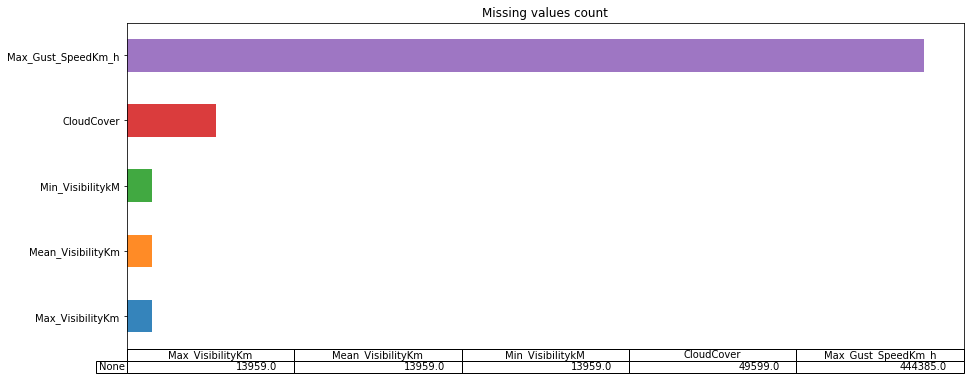

In [6]:
# Missing values# 
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

## Max_Gust_SpeedKm_h

In [7]:
all_data=all_data.drop('Max_Gust_SpeedKm_h',axis=1)
all_data.shape

(568710, 33)

## CloudCover & Visibility

In [8]:
nan_index=all_data[all_data['CloudCover'].isnull()].index.tolist()
# for i in nan_index:
#     curr_date = all_data.loc[i,'Date']
#     curr_region = all_data.loc[i,'Region']
#     regional_stores = all_data[(all_data.Date == curr_date) & (all_data.Region == curr_region)]
#     curr_mode = regional_stores['CloudCover'].mode()


# 

## Time - sales visualization

In [9]:
stores = {}
for storeid in train.StoreID.unique():
    stores[storeid] = pd.DataFrame(train[train["StoreID"] == storeid])
    stores[storeid] = stores[storeid].set_index("Date")

KeyboardInterrupt: 

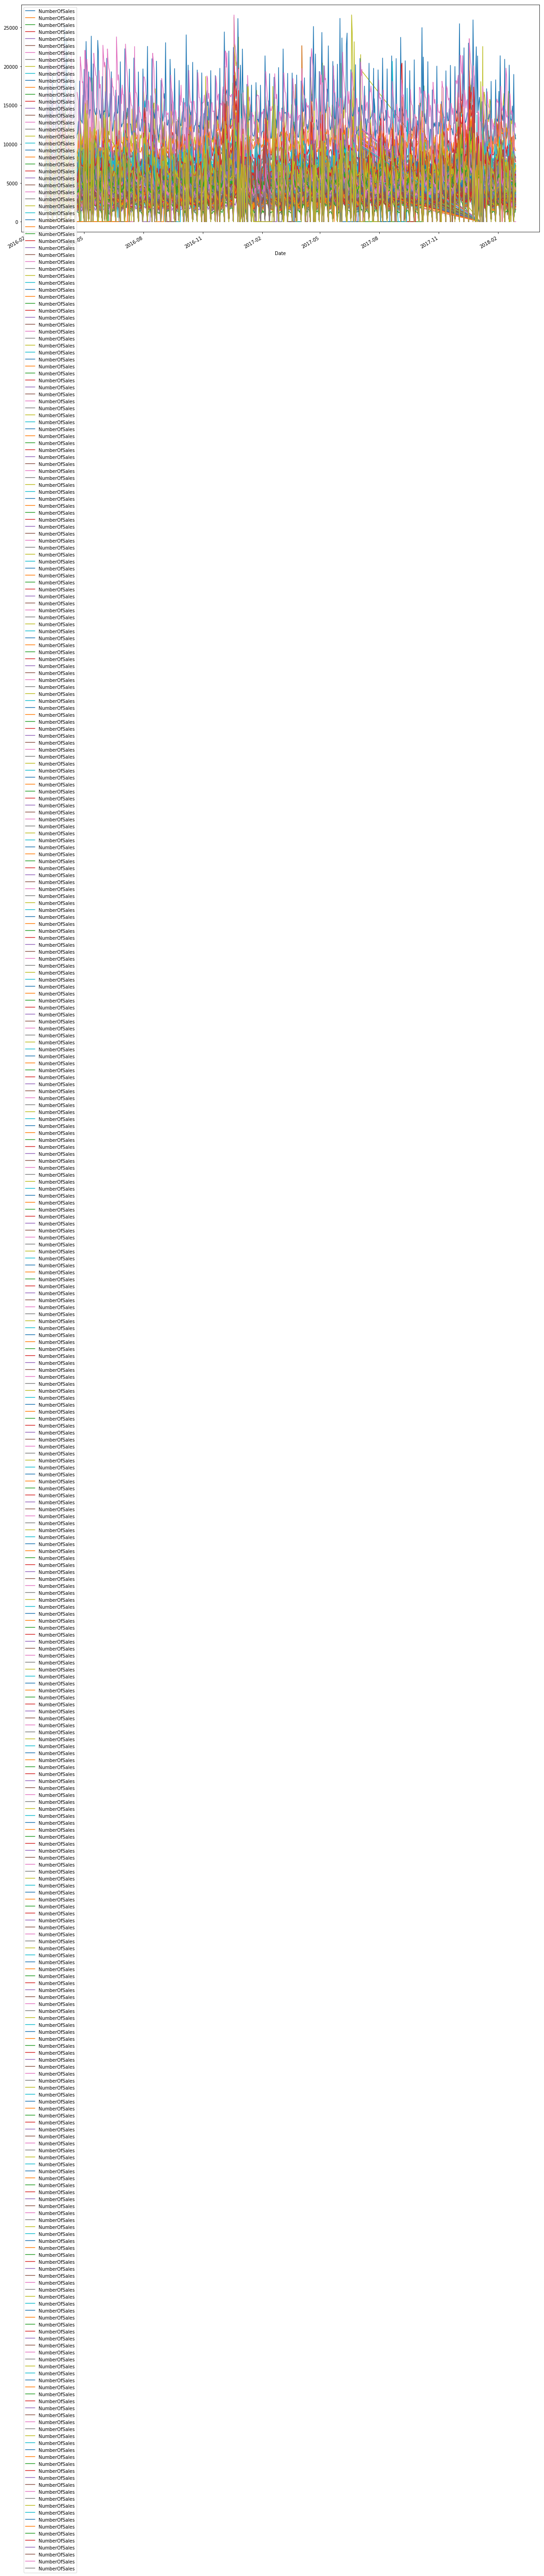

In [12]:
ax = stores[1000].plot(y="NumberOfSales",figsize=(20,10))
for key,store in stores.items():
    store.plot(ax=ax, y="NumberOfSales")

In [17]:
train_byRegion = train.groupby('Region')

for region,regStores in train_byRegion:
    print(region)
    #plt.subplot2grid((11,1),(region,0))
    #print(region)
    #print(regStores)
    
    for key, store in regStores.groupby('StoreID'):
        store.plot(x="Date", y="NumberOfSales",figsize=(20,10))
        #sns.tsplot(data=store, time='Date', value='NumberOfSales')
        
        #store.NumberOfr
    #for store pin regStores
    #for key, store in regStores.items():
    #    print(type(store))
        #store.NumberOfSales.resample('M').sum().plot(figsize=(20,10))
        
    

0


KeyError: 'Column not found: 0'

In [ ]:
store